# Data modeling

### Questões norteadoras

1. Quais fatores influenciam para um colaborador deixar a empresa
2. Como reter pessoas?
3. Podemos nos antecipar e saber se um determinado colaborador vai sair da empresa?
4. Como diminuir o Turnover

### Datasets

* accident.csv
* employees.csv
* projects_emp.csv
* salaries.csv
* employee_performance_evaluation.json
* employee_date_hour_0.xlsx (0 até 5)

### Imports

In [2]:
import pandas as pd
import json
import glob
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from pycaret.classification import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Criando Dataframes

In [52]:
dfEmployees_Perfomance_Evaluantion = pd.read_json('employee_performance_evaluation.json',orient='records',lines=True)
dfAccident = pd.read_csv('accident.csv', names=['emp_no','Event Description','Event Keywords', 'Human Factor'])
dfProjects_Emp = pd.read_csv('projects_emp.csv', names=['emp_id','project_id'])
dfSalaries = pd.read_csv('salaries.csv', names=['emp_id','salary'])
dfEmployees = pd.read_csv('employees.csv', names=['emp_no','birth_date','first_name','last_name','gender','departament','left','hire_date'])

### Criando feature 'Number of projects'

In [53]:
dfNumber_Projects = dfProjects_Emp.groupby('emp_id').count().reset_index()
dfNumber_Projects.rename(columns={'project_id':'number_projects'},inplace=True)

### Criando feature 'Average work in the last three months'

In [54]:
dfPoint_System = pd.DataFrame(data=None, columns=['emp_id','data','hora'])
for sheet in glob.glob('*xlsx'):
    dfAux = pd.read_excel(sheet)
    dfPoint_System = pd.concat([dfPoint_System,dfAux])

In [55]:
dfLast_Work_Three_Months = dfPoint_System[(dfPoint_System['data'] > datetime.datetime(2020,9,30))]

mean_Work_Last_Three_Months = dfLast_Work_Three_Months.groupby('emp_id')['hora'].agg('sum')/3

dfMean_Work_Last_Three_Months = pd.DataFrame(mean_Work_Last_Three_Months).reset_index()

dfMean_Work_Last_Three_Months.rename(columns={'hora':'mean_work_last_three_months'}, inplace=True)

### Criando feature 'Number of years at the Company'

In [56]:
date_reference = datetime.date(2021,1,1)
dfEmployees['hire_date'] = pd.to_datetime(dfEmployees['hire_date'])
days_diff = []
nyears = []

for day in dfEmployees['hire_date']:
    diff = date_reference - day.date()
    days_diff.append(diff.days)
    
for ndays in days_diff:
    nyears.append(int(math.ceil(ndays / 365)))
    
#dfEmployees['time_in_company'] = nyears

In [57]:
work_Accident = []
for emp in dfEmployees['emp_no']:
    if emp in dfAccident['emp_no'].to_list():
        work_Accident.append(1)
    else:
        work_Accident.append(0)
        
#dfEmployees['work_accident'] = work_Accident

### Selecionando features para o dataFrame

In [58]:
df = pd.merge(dfEmployees,dfSalaries,left_on='emp_no',right_on='emp_id' ).drop(columns='emp_id')
df = pd.merge(df,dfMean_Work_Last_Three_Months,left_on='emp_no',right_on='emp_id' ).drop(columns='emp_id')
df = pd.merge(df,dfEmployees_Perfomance_Evaluantion,left_on='emp_no',right_on='emp_id' ).drop(columns='emp_id')
df = pd.merge(df,dfNumber_Projects,left_on='emp_no',right_on='emp_id' ).drop(columns='emp_id')
df['time_in_company'] = nyears
df['work_accident'] = work_Accident


In [59]:
df = df[['gender', 'departament', 'salary', 'mean_work_last_three_months',
       'satisfaction_level', 'last_evaluation', 'number_projects',
       'time_in_company', 'work_accident', 'left']]

In [60]:
 df[['satisfaction_level','last_evaluation','number_projects','time_in_company','work_accident','left','mean_work_last_three_months']] = df[['satisfaction_level','last_evaluation','number_projects','time_in_company','work_accident','left','mean_work_last_three_months']].apply(pd.to_numeric)

# Análise exploratória

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       14999 non-null  object 
 1   departament                  14999 non-null  object 
 2   salary                       14999 non-null  object 
 3   mean_work_last_three_months  14999 non-null  float64
 4   satisfaction_level           14999 non-null  int64  
 5   last_evaluation              14999 non-null  int64  
 6   number_projects              14999 non-null  int64  
 7   time_in_company              14999 non-null  int64  
 8   work_accident                14999 non-null  int64  
 9   left                         14999 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 1.3+ MB


### Checando valores ausentes

In [62]:
df.isnull().sum()

gender                         0
departament                    0
salary                         0
mean_work_last_three_months    0
satisfaction_level             0
last_evaluation                0
number_projects                0
time_in_company                0
work_accident                  0
left                           0
dtype: int64

### Estrutura do dataFrame

In [63]:
df.shape

(14999, 10)

### Visão geral das estatísticas

In [64]:
df.describe()

,mean_work_last_three_months,satisfaction_level,last_evaluation,number_projects,time_in_company,work_accident,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,276.021490,61.283352,71.610174,3.803054,3.498233,0.144610,0.238083
std,10.048839,24.863065,17.116911,1.232592,1.460136,0.351719,0.425924
min,232.333333,9.000000,36.000000,2.000000,2.000000,0.000000,0.000000
25%,269.333333,44.000000,56.000000,3.000000,3.000000,0.000000,0.000000
50%,276.000000,64.000000,72.000000,4.000000,3.000000,0.000000,0.000000
75%,282.666667,82.000000,87.000000,5.000000,4.000000,0.000000,0.000000
max,321.333333,100.000000,100.000000,7.000000,10.000000,1.000000,1.000000


### Visão geral da rotatividade

In [65]:
turnover_rate = df.left.value_counts() / len(df)
turnover_rate

0    0.761917
1    0.238083
Name: left, dtype: float64

In [66]:
turnover_summary = df.groupby('left')
turnover_summary.mean()

,mean_work_last_three_months,satisfaction_level,last_evaluation,number_projects,time_in_company,work_accident
left,,,,,,
0,276.042585,66.680959,71.547340,3.786664,3.380032,0.175009
1,275.953981,44.009801,71.811257,3.855503,3.876505,0.047326


O conjunto de dados tem:

- 14.999 observações de empregados e 10 atributos.
- A empresa tem uma rotatividade de 24%.
- A satisfação média dos empregados que contiuam na empresa é de 66.
- A satisfação média dos empregados que deixaram a empresa é 44.

### Matriz de correlação e Mapa de calor

,mean_work_last_three_months,satisfaction_level,last_evaluation,number_projects,time_in_company,work_accident,left
mean_work_last_three_months,1.000000,0.007780,-0.007111,-0.009744,0.004990,0.011836,-0.003756
satisfaction_level,0.007780,1.000000,0.105021,-0.142970,-0.100866,0.058697,-0.388375
last_evaluation,-0.007111,0.105021,1.000000,0.349333,0.131591,-0.007104,0.006567
number_projects,-0.009744,-0.142970,0.349333,1.000000,0.196786,-0.004741,0.023787
time_in_company,0.004990,-0.100866,0.131591,0.196786,1.000000,0.002120,0.144822
work_accident,0.011836,0.058697,-0.007104,-0.004741,0.002120,1.000000,-0.154622
left,-0.003756,-0.388375,0.006567,0.023787,0.144822,-0.154622,1.000000


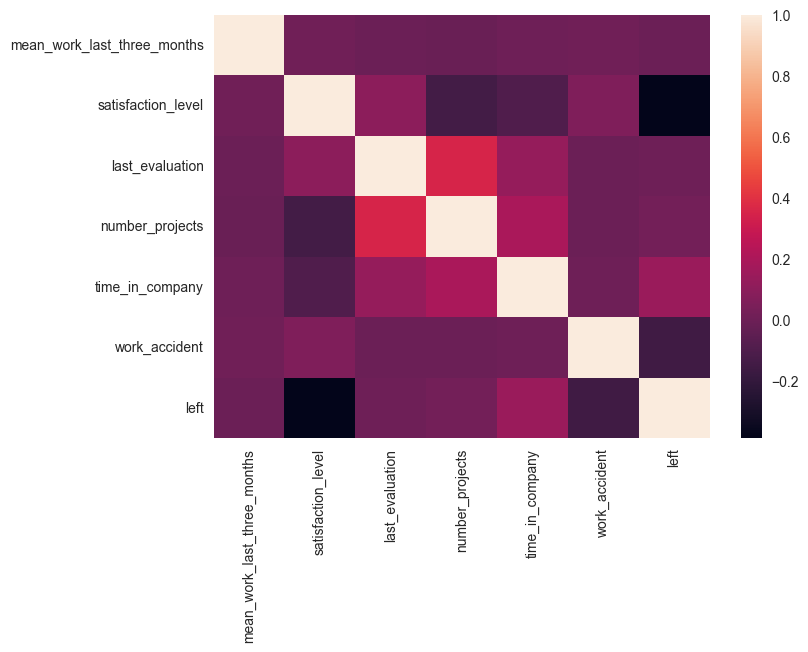

In [67]:
corr = df.corr()
#orr = (corr)
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values
           )

corr


***
**Atributos com uma correlação moderada positiva:** 
- number_projects vs last_evaluation: 0.34
- time_in_company vs number_projects: 0.19

**Atributos com uma correlação moderada negativa:**
 - satisfaction_level vs left:  -0.38

**Questões:**
- Quais atributos afetam nossa variável alvo (turnover)?
- Existem atributos com alta correlação entre eles?
- Como podemos aprofundar para entender as correlações?

**Resumo:**

Existe uma **correlação positiva** entre os atributos number_projects e last_evaluation.

Faz sentido que empregados que estão envolvidos em mais projetos, trabalham mais e tem melhor avaliação.

Existe uma **correlação negativa** entre os atributos satisfaction_level e left.

Podemos assumir que empregados que mais deixam a empresa estão menos satisfeitos.

### Calculando a distribuição dos atributos

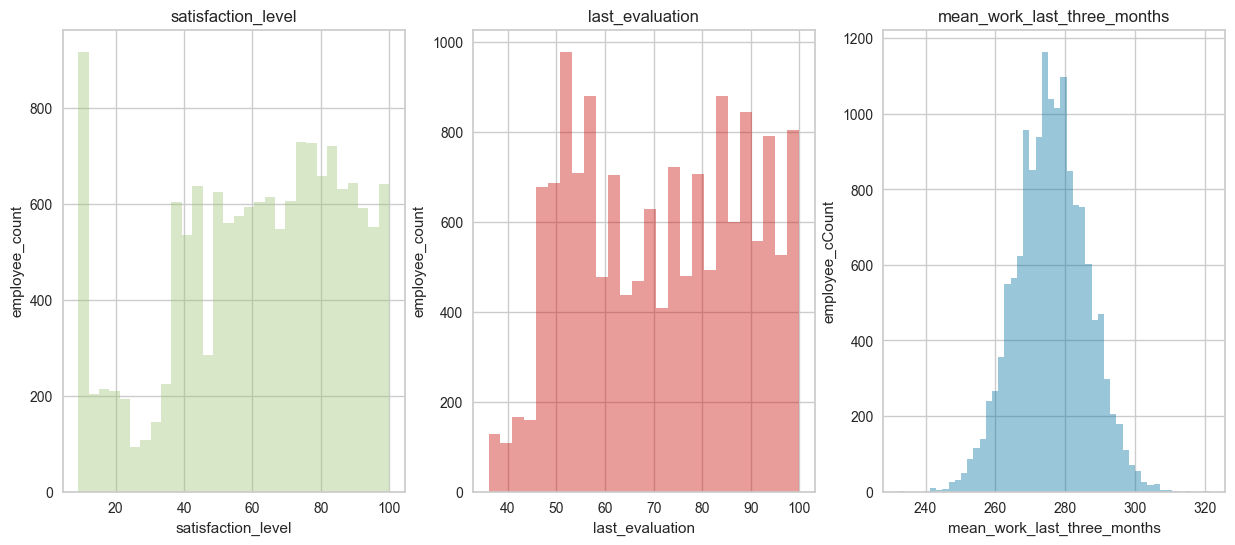

In [68]:
f, axes = plt.subplots(ncols=3, figsize=(15, 6))

sns.distplot(df.satisfaction_level, kde=False, color='g', ax=axes[0]).set_title('satisfaction_level')
axes[0].set_ylabel('employee_count')

sns.distplot(df.last_evaluation, kde=False, color='r', ax=axes[1]).set_title('last_evaluation')
axes[1].set_ylabel('employee_count')

sns.distplot(df.mean_work_last_three_months, kde=False, color='b', ax=axes[2]).set_title('mean_work_last_three_months')
axes[2].set_ylabel('employee_cCount')
plt.show()

### Distribuiçöes (Satisfação - Avaliação - Média de horas trabalhadas)
***
**Summary:** Examinando a distribuição de alguns atributos do conjunto de dados:
 - **satisfaction_level** - Existe um pico de empregados com baixa satisfação mas a maior concentração está em 60 a 80.
 - **last_evaluation** - Temos uma distribuição bimodal de empregados com avaliações baixas, menor que de 60 e altas, maior que 80.
 - **mean_work_last_three_months** - A concentração da quantidade de horas trabalhadas nos últimos 3 meses está ao redor da média em 275 horas.
 
**Questões:** 
 - Existe uma razão para o pico de empregados insatisfeitos?

### Verificando o rotatividade em relação ao salário

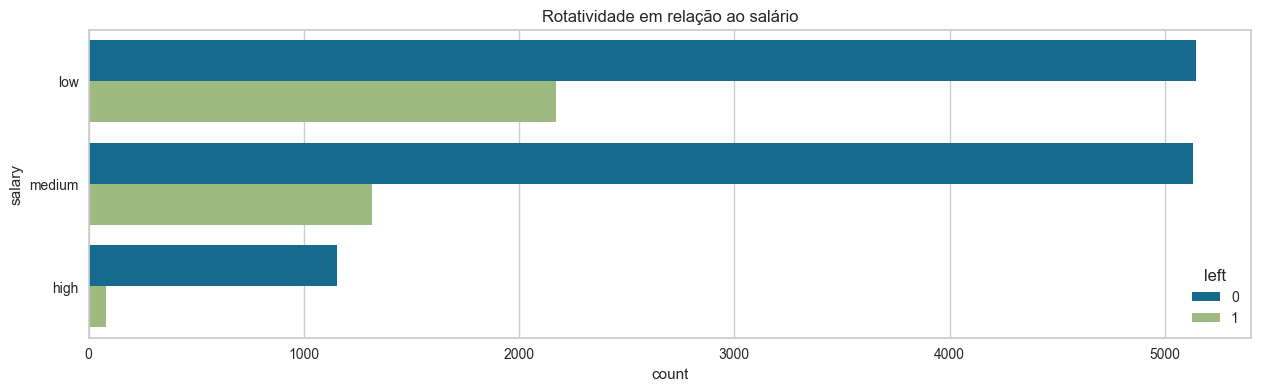

In [69]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y='salary', hue='left', data=df).set_title('Rotatividade em relação ao salário');

***
**Summary:**
 - A maioria dos empregados que saíram tinha salário **baixo** ou **médio**.
 - Quase nenhum empregado com alto salário deixou a empresa.
 
**Questões:** 
 - Como é o ambiente de trabalho? Isso se difere por salário?
 - O que faz empregados com alto salário sairem da empresa.

### Verificando o turnover em relação departamento.

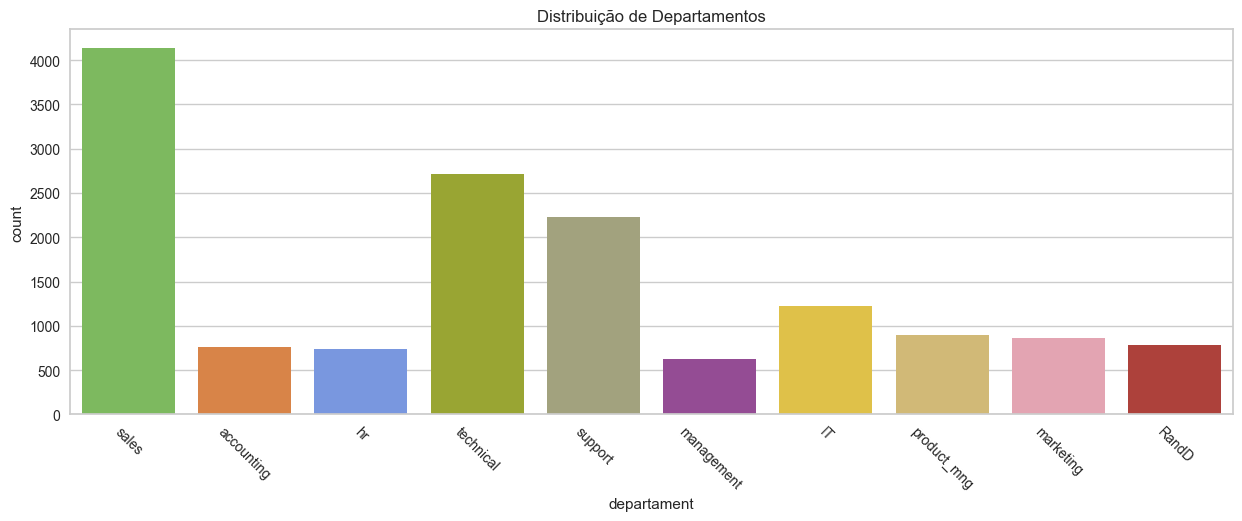

In [70]:
f, ax = plt.subplots(figsize=(15, 5))
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
                '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']
plt.xticks(rotation=-45)

sns.countplot(x='departament', data=df, palette=color_types).set_title('Distribuição de Departamentos');

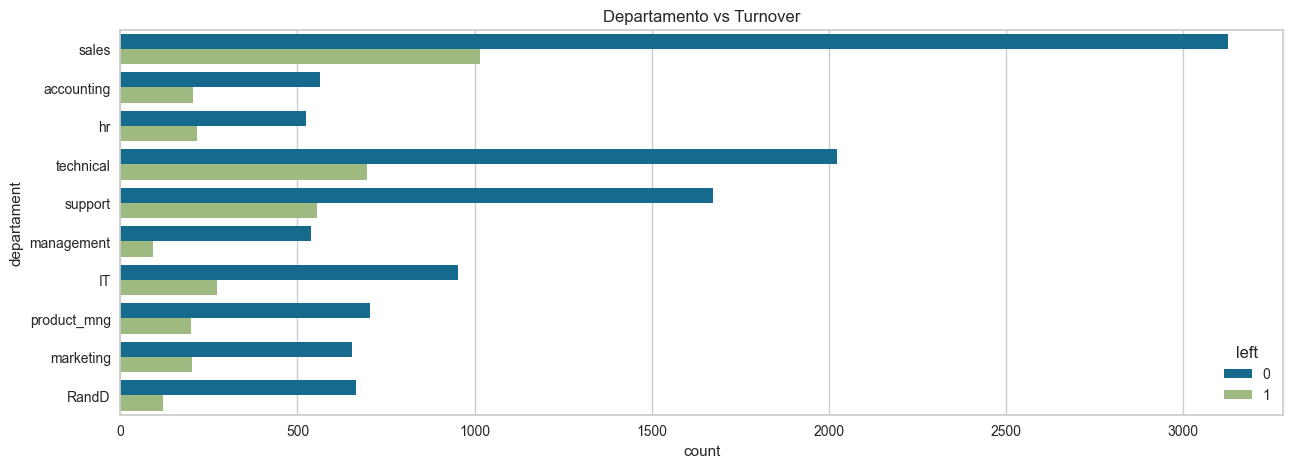

In [71]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y='departament', hue='left', data=df).set_title('Departamento vs Turnover');

***
**Resumo:** Vamos ver mais informações sobre os departamentos da empresa.
 - Os departamentos de vendas, técnico e suporte são top 3 departamentos com maior índice de turnover.
 - O departamento management tem o menor volume de turnover.

**Questões:** 
 - Será que examinar em profundidade os departamentos que tem maior índice de turnover e o menor pode nos revelar mais    informações importantes?
 - Qual o salário nestes departamentos?

### Verificando o turnover em relação ao número de projetos.

[]

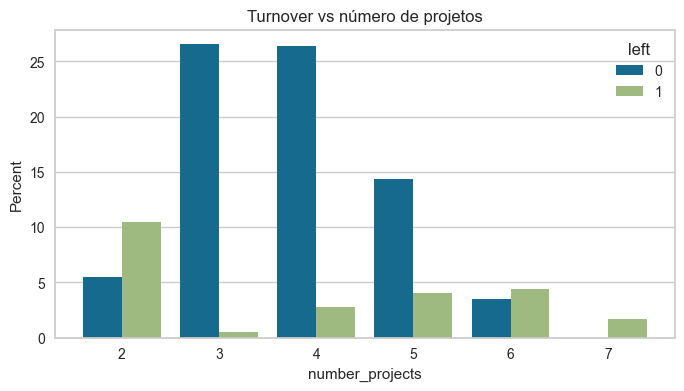

In [72]:
fig = plt.figure(figsize=(8,4),)
ax = sns.barplot(x='number_projects', y='number_projects', hue='left', data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel='Percent')
plt.title('Turnover vs número de projetos')
plt.plot()

**Resumo:** Insights interessantes que encontramos aqui:
 - Mais da metade dos empregados com **2 e 6 projetos** deixam a empresa.
 - A maioria dos empregados que permancem na empresa estão envolvidos de **3 à 5 projetos**.
 - Todos os empregados que estavam inseridos **7 projetos** deixaram a empresa.
 - Existe uma pequena **tendência de crescimento no índice de turnover** em relação à quantidade de projetos.
 
**Questões:**
 - Porque os empregados estão deixando a empresa em relação a quantidade de projetos ?
 - Será que faz sentido pensar que empregados envolvidos em 2 ou menos projetos estão desmotivados e por isso deixam a empresa?
 - Será que empregados envolvidos em mais que 6 projetos se sintam sobrecarregados e deixam a empresa?

### Verificando o turnover em relação a nota de avaliação.

[]

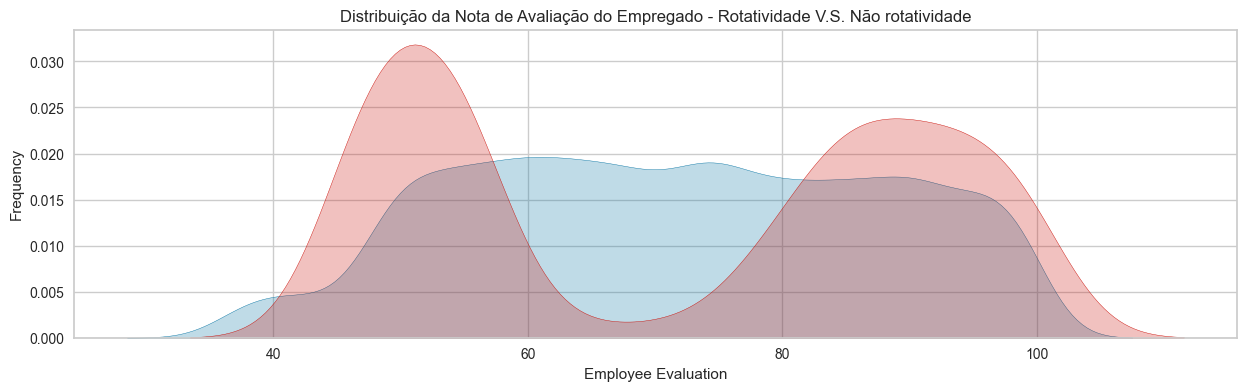

In [73]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['left'] == 0),'last_evaluation'] , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(df.loc[(df['left'] == 1),'last_evaluation'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Employee Evaluation', ylabel='Frequency')
plt.title('Distribuição da Nota de Avaliação do Empregado - Rotatividade V.S. Não rotatividade')
plt.plot()

**Resumo:** 
 - Temos uma distribuição bimodal para o conjunto que deixou a empresa.
 - Colaboradores com **baixa performance** tendem a deixar a empresa.
 - Colaboradores com **alta performance** tendem a deixar a empresa.
 - O **ponto ideal** para os funcionários que permaneceram está dentro da avaliação de 60 à 80.

### Verificando o turnover em relação a satisfação do empregado.

[]

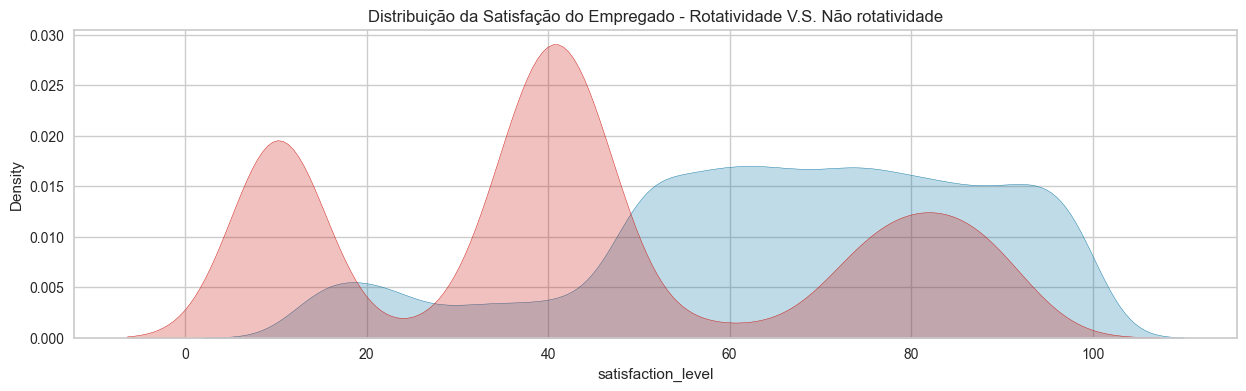

In [74]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['left'] == 0),'satisfaction_level'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['left'] == 1),'satisfaction_level'] , color='r',shade=True, label='turnover')
plt.title('Distribuição da Satisfação do Empregado - Rotatividade V.S. Não rotatividade')
plt.plot()

**Resumo:** 
 - Empregados com o nível de satisfação em 20 ou menos tendem a deixar a empresa.
 - Empregados com o nível de satisfação em até 50 tem maior probabilidade de deixar a empresa.

### Verificando a relação entre número de projetos e a nota de avaliação do empregado.

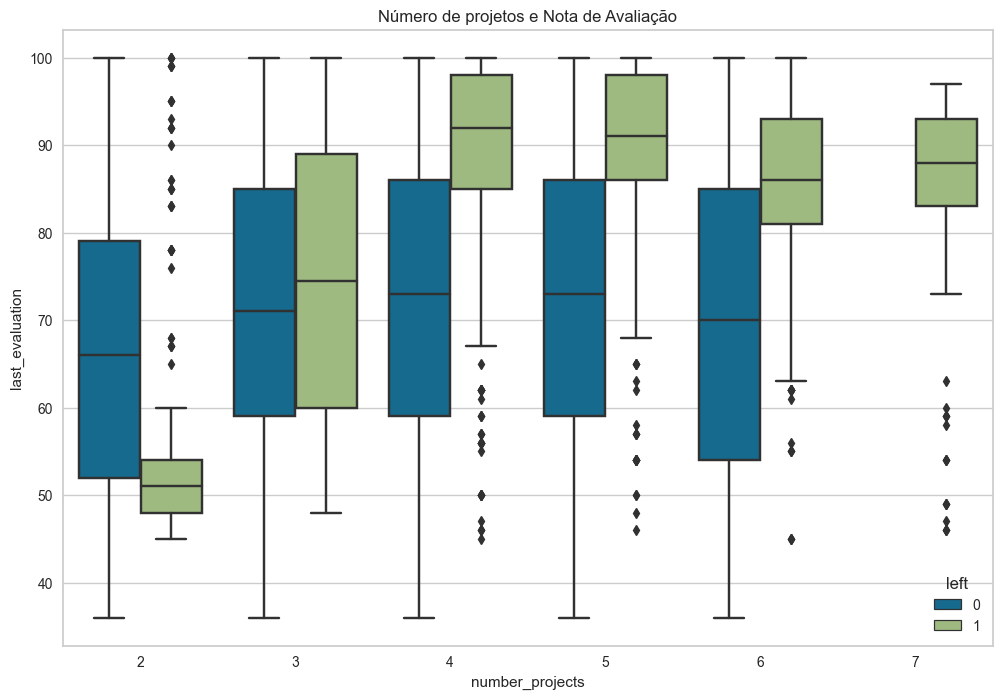

In [75]:
 fig = plt.figure(figsize=(12, 8))
import seaborn as sns
sns.boxplot(x='number_projects', y='last_evaluation', hue='left', data=df)
plt.title('Número de projetos e Nota de Avaliação')
plt.show()

**Resumo:** 
- Há um **aumento na avaliação** para os funcionários que realizaram mais projetos dentro do grupo de quem deixou a empresa. 
- Para o grupo de pessoas que permaneceram na empresa, os empregados tiveram uma **pontuação de avaliação consistente**, apesar do aumento nas contagens de projetos.
- Empregados que permaneceram na empresa tiveram uma **avaliação média em torno de 70%**, mesmo com o número de projetos crescendo.
- Esta relação muda drasticamente entre os empregados que deixaram a empresa. A partir de 3 projetos, as **médias de avaliação aumentam consideravelmente**.
- Empregados que tinham **dois projetos e uma péssima avaliação** saíram.
- Empregados com **mais de 3 projetos e avaliações altas** deixaram a empresa.

**Questões:**
  - Por que será que os funcionários que saíram tiveram em média uma avaliação superior aos funcionários que não saíram, mesmo com um aumento no número de projetos?
  - Os funcionários com avaliações mais baixas não deveriam ter tendência a sair mais da empresa?

### Verificando a relação entre a satisfação do empregado e a sua avaliação.

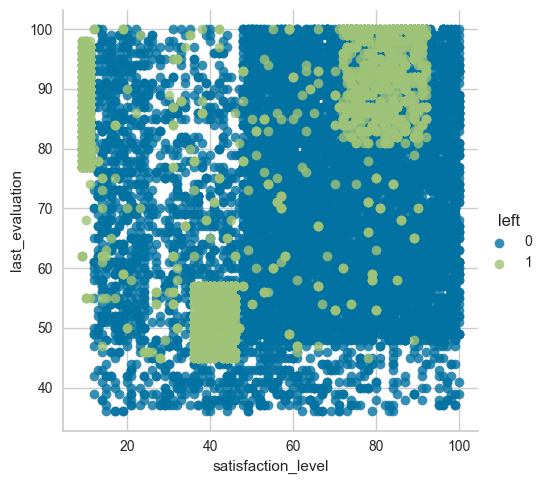

In [76]:
sns.lmplot(x = 'satisfaction_level', 
           y = 'last_evaluation', 
           data = df,
           fit_reg = False,
           hue='left')

**Resumo:**: Temos aqui 3 grupos distintos de empregados.
 
**Cluster 1 (Empregados insatisfeitos e trabalhadores):** A satisfação foi inferior a 20 e as avaliações foram superiores a 75. 
- O que pode ser uma boa indicação de que os funcionários que deixaram a empresa eram bons trabalhadores, mas se sentiam péssimos no trabalho.

Questões: 
 - Qual poderia ser o motivo de se sentir tão mal quando você é altamente avaliado? 
 - Será que está trabalhando muito? 
 - Esse cluster poderia significar funcionários que estão 'sobrecarregados'? 
 
**Cluster 2 (Empregados ruins e insatisfeitos):** Satisfação entre 35 à 50 e as suas avaliações abaixo de ~ 58. 

Questões:
- Isso pode ser visto como funcionários que foram mal avaliados e se sentiram mal no trabalho.
- Podemos chamar esse grupo de baixo desempenho?

**Cluster 3 (Empregados satisfeitos e trabalhadores):** Satisfação entre 75 à 90 e avaliações superiores a 80. 
- O que poderia significar que os funcionários neste grupo eram 'ideais'. 
- Eles amavam seu trabalho e eram altamente avaliados por seu desempenho.

Questões: 
- Este grupo pode representar os empregados que deixaram a empresa porque encontraram outra oportunidade de trabalho?
- Poderiamos ter mais do que 3 clusters?

### Computando os clusters

In [77]:
kmeans = KMeans(n_clusters=3,random_state=2)

In [78]:
df_turnover = df[df.left==1][['satisfaction_level','last_evaluation']]

In [79]:
kmeans.fit(df_turnover)

KMeans(algorithm='lloyd', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init='warn', random_state=2, tol=0.0001, verbose=0)

In [80]:
kmeans_colors = ['green' if c == 0 else 'red' if c == 1 else 'blue' for c in kmeans.labels_]

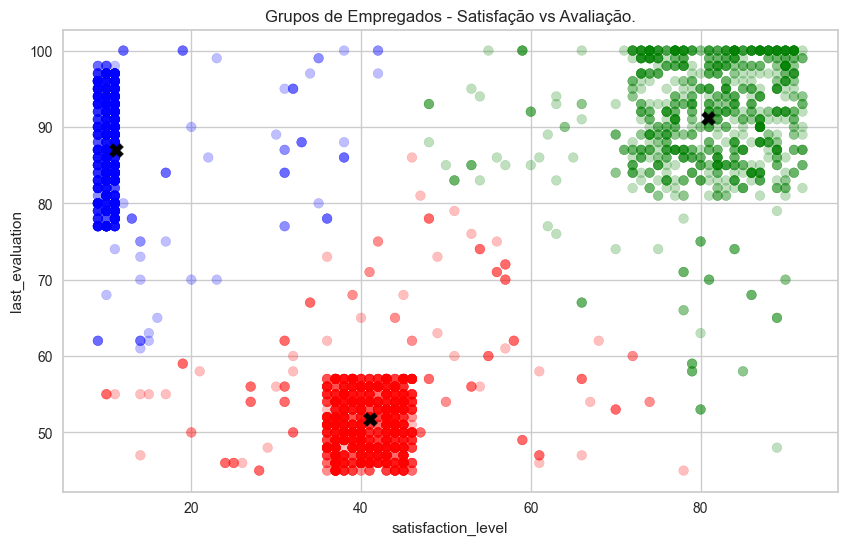

In [81]:
fig = plt.figure(figsize=(10, 6))
plt.scatter( x='satisfaction_level'
            ,y='last_evaluation'
            ,data=df_turnover,
            alpha=0.25,color = kmeans_colors)

plt.xlabel('satisfaction_level')
plt.ylabel('last_evaluation')

plt.scatter( x=kmeans.cluster_centers_[:,0]
            ,y=kmeans.cluster_centers_[:,1]
            ,color='black'
            ,marker='X',s=100)

plt.title('Grupos de Empregados - Satisfação vs Avaliação.')
plt.show()

### K-Means Grupos
***
**Cluster 0 (Verde):** Empregados trabalhadores e satisfeitos.

**Cluster 1 (Vermelho):** Empregados ruins e insatisfeitos. 

**Cluster 2 (Azul):** Empregados trabalhadores e tristes.

### Verificando a relação entre o tempo de empresa e o turnover.

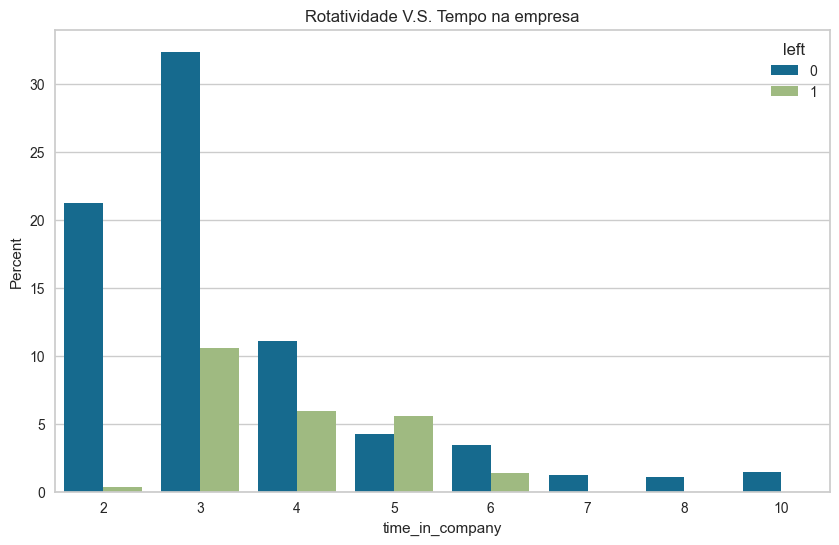

In [82]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x='time_in_company', y='time_in_company', hue='left', data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel='Percent')
plt.title('Rotatividade V.S. Tempo na empresa')
plt.show()

**Resumo:** Vamos ver mais alguns pontos para entender o porque os empregados deixam a empresa.
 - Empregados com **4 e 6 anos de casa** deixaram a empresa.
 - Empregados acima de **6 anos de casa** devem ser examinados.
 
**Questões:**
  - Por que os Empregados estão saindo principalmente na faixa de 3-6 anos?
  - Quem são esses Empregados que saíram?

# Machinhe Learning

### Criando uma cópia do dataFrame

In [83]:
df_ml = df.copy()

### Trasnformando as features categóricas em códigos

In [84]:
df_ml['gender'] = df_ml['gender'].astype('category').cat.codes
df_ml['departament'] = df_ml['departament'].astype('category').cat.codes
df_ml['salary'] = df_ml['salary'].astype('category').cat.codes

### Criando os dataFrames de Treino e Validação

In [85]:
df_model = df_ml.sample(frac=0.95, random_state=786)
df_validation = df_ml.drop(df_model.index)

In [86]:
df_model.reset_index(inplace=True, drop=True)
df_validation.reset_index(inplace=True, drop=True)

In [87]:
print('Data frame para treino: ',df_model.shape )
print('Data frame para validação: ',df_validation.shape )

Data frame para treino:  (14249, 10)
Data frame para validação:  (750, 10)


### Inicializando o setup do Pycaret

In [88]:
s = setup( df_model
          ,target = 'left'
          ,categorical_features=['gender','departament','salary']
          ,numeric_features=['mean_work_last_three_months','satisfaction_level','last_evaluation','number_projects','time_in_company','work_accident']
          ,normalize = True
          ,normalize_method = 'minmax'
          ,data_split_stratify = True
          ,fix_imbalance = True 
         )
     

,Description,Value
0,Session id,1833
1,Target,left
2,Target type,Binary
3,Original data shape,"(14249, 10)"
4,Transformed data shape,"(19493, 21)"
5,Transformed train set shape,"(15218, 21)"
6,Transformed test set shape,"(4275, 21)"
7,Ordinal features,1
8,Numeric features,6
9,Categorical features,3


In [89]:
s.get_config()

{'USI',
 'X',
 'X_test',
 'X_test_transformed',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '_available_plots',
 '_ml_usecase',
 'data',
 'dataset',
 'dataset_transformed',
 'exp_id',
 'exp_name_log',
 'fix_imbalance',
 'fold_generator',
 'fold_groups_param',
 'fold_shuffle_param',
 'gpu_n_jobs_param',
 'gpu_param',
 'html_param',
 'idx',
 'is_multiclass',
 'log_plots_param',
 'logging_param',
 'memory',
 'n_jobs_param',
 'pipeline',
 'seed',
 'target_param',
 'test',
 'test_transformed',
 'train',
 'train_transformed',
 'variable_and_property_keys',
 'variables',
 'y',
 'y_test',
 'y_test_transformed',
 'y_train',
 'y_train_transformed',
 'y_transformed'}

In [90]:
list(s.get_config('y')).count(0),list(s.get_config('y')).count(1)

(10871, 3378)

In [91]:
list(s.get_config('y_transformed')).count(0),list(s.get_config('y_transformed')).count(1)

(10871, 8622)

### Comparando os modelos

In [92]:
best = compare_models(fold = 10,sort = 'AUC', cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9771,0.9892,0.9370,0.9659,0.9510,0.9361,0.9365,4.3150
lightgbm,Light Gradient Boosting Machine,0.9766,0.9890,0.9323,0.9681,0.9497,0.9345,0.9349,0.1850
rf,Random Forest Classifier,0.9775,0.9878,0.9273,0.9769,0.9513,0.9367,0.9374,0.2610
xgboost,Extreme Gradient Boosting,0.9746,0.9869,0.9307,0.9615,0.9456,0.9290,0.9295,0.2380
et,Extra Trees Classifier,0.9728,0.9868,0.9226,0.9613,0.9415,0.9238,0.9242,0.2630
gbc,Gradient Boosting Classifier,0.9686,0.9858,0.9226,0.9442,0.9330,0.9125,0.9129,0.3800
ada,Ada Boost Classifier,0.9417,0.9747,0.8985,0.8629,0.8798,0.8414,0.8422,0.1480
dt,Decision Tree Classifier,0.9582,0.9483,0.9294,0.8979,0.9133,0.8858,0.8860,0.1140
knn,K Neighbors Classifier,0.9140,0.9444,0.8782,0.7853,0.8289,0.7717,0.7741,0.4700
qda,Quadratic Discriminant Analysis,0.8384,0.9059,0.8203,0.6273,0.7084,0.6002,0.6126,0.0500


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

### Cruva ROC e AUC
**ROC é uma curva de probabilidade.** Ela é criada traçando a **taxa verdadeiro-positivo contra a taxa de falsos-positivos.** Ou seja, numero de vezes que o classificador acertou a predição conta o número de vezes que o classificador errou a predição.

O **AUC** representa o grau ou **medida de separabilidade**. Quanto maior o AUC, melhor o modelo está em prever 0s como 0s e 1s como 1s. Por exemplo, quanto maior a AUC, melhor o modelo está em distinguir entre pacientes com doença e pacientes sem doença.

Assim, para simplificar a curva ROC, foi criada a AUC. A **AUC resume a curva ROC num único valor**, calculando a “área sob a curva”.

![ChessUrl](https://github.com/dariyasydykova/open_projects/raw/master/ROC_animation/animations/ROC.gif "chess")

In [93]:
lightgbm = create_model('lightgbm', fold = 10, cross_validation=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9810,0.9946,0.9536,0.9658,0.9597,0.9472,0.9472
1,0.9749,0.9900,0.9451,0.9492,0.9471,0.9307,0.9307
2,0.9770,0.9905,0.9367,0.9652,0.9507,0.9357,0.9359
3,0.9699,0.9890,0.9114,0.9600,0.9351,0.9155,0.9160
4,0.9689,0.9832,0.8983,0.9680,0.9319,0.9118,0.9128
5,0.9769,0.9883,0.9237,0.9776,0.9499,0.9349,0.9356
6,0.9789,0.9905,0.9364,0.9736,0.9546,0.9409,0.9412
7,0.9789,0.9901,0.9576,0.9536,0.9556,0.9418,0.9418
8,0.9789,0.9943,0.9534,0.9574,0.9554,0.9416,0.9416


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [94]:
predict_model(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9759,0.9902,0.9269,0.9700,0.9480,0.9323,0.9327


,gender,departament,salary,mean_work_last_three_months,satisfaction_level,last_evaluation,number_projects,time_in_company,work_accident,left,prediction_label,prediction_score
6440,1,2,1,275.000000,66,74,4,3,0,0,0,0.9862
10568,1,9,2,284.000000,90,57,4,4,0,0,0,0.9883
10085,0,1,2,274.666656,71,76,3,2,0,0,0,0.9967
14132,1,8,1,262.333344,10,77,5,4,0,1,1,0.9997
3213,0,0,2,262.333344,19,64,5,4,1,0,0,0.9740
...,...,...,...,...,...,...,...,...,...,...,...,...
1873,1,7,1,270.333344,78,99,4,6,0,1,1,0.9780
13314,0,0,1,274.000000,74,82,4,6,0,1,1,0.7943
6507,0,2,0,276.333344,71,60,4,3,0,0,0,0.9992
3859,1,6,0,288.333344,94,67,4,3,1,0,0,0.9999


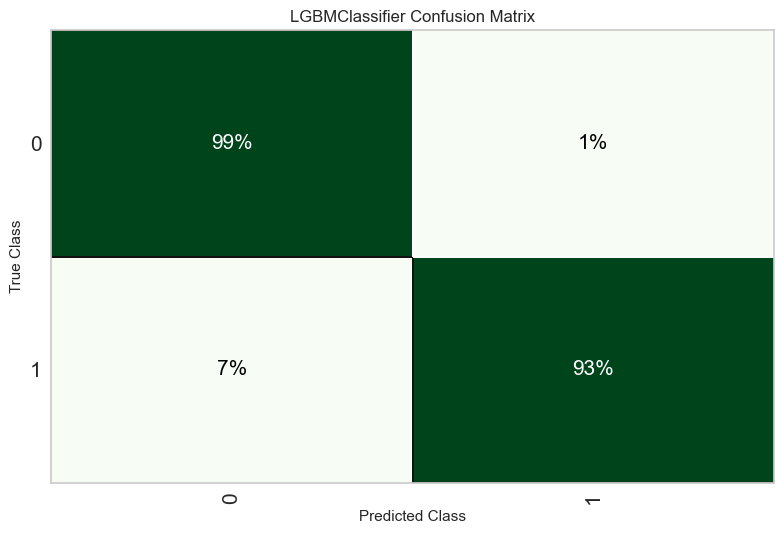

In [95]:
plot_model(lightgbm,plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

In [96]:
validation_predictions = predict_model(lightgbm, data=df_validation)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9827,0.9943,0.9378,0.9945,0.9653,0.9538,0.9545


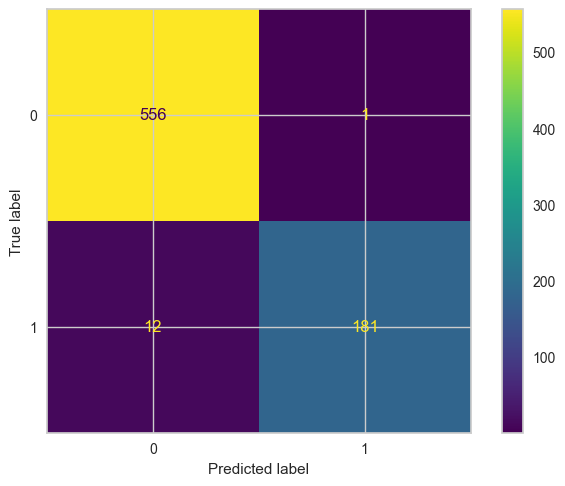

In [97]:
confusion_matrix = metrics.confusion_matrix(validation_predictions['left'], validation_predictions['prediction_label'],labels=[0, 1])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()

plt.show()